# What is the Best Neighborhood in Pittsburgh?

### This notebook uses three metrics, number of dangerous arrests, number of fire incidents, and number of trees, to determine which neighborhood in Pittsburgh is the best.

#### This section analyzes a data set of arrests in the city of Pittsburgh to determine which neighborhood is the nicest to live in. Each arrest is assigned a point value based on the crime(s) commited. After each arrest is tallied up, the neighborhoods with the lowest scores are deemed the best neighborhoods for this metric.

In [1]:
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline

The first cell of code is to import the necessary data structures for the analysis of the data.

In [2]:
arrests_data = pd.read_csv("Arrests.csv")

This cell initializes the data that will be used for this analysis. Since there is so much unnecessary data in this set, it it more useful to only look at specific columns of the data.

In [3]:
print(arrests_data.iloc[:,7].head(20))
print("------------------------------------")
print("There are",len(arrests_data),"items in this data set.")

0                                    3929 Retail Theft.
1          13(a)(16) Possession of Controlled Substance
2                                    3929 Retail Theft.
3     5503 Disorderly Conduct. / 5505 Public Drunken...
4     2702 Aggravated Assault. / 2705 Recklessy Enda...
5                                    3929 Retail Theft.
6                                  2701 Simple Assault.
7     2701 Simple Assault. / 5505 Public Drunkenness...
8              903 Criminal Conspiracy. / 3701 Robbery.
9     3127 Indecent Exposure. / 3123(a)(6) IDSI with...
10    2701 Simple Assault. / 3304 Criminal Mischief....
11                                 2701 Simple Assault.
12              5507 Obstructing Highways and Passages.
13    3921(a) Theft by Unlawful Taking or Dispositio...
14    5123 Contraband. / 13(a)(16) Possession of Con...
15             903 Criminal Conspiracy. / 3701 Robbery.
16    5505 Public Drunkenness / 13(a)(32) Parapherna...
17    6106 Firearms not to be Carried without a 

The output above is the arrests data organized by offenses. There are 47277 offenses in this data set, which began tracking arrests since 2016. This program displays the first 20 offenses in the dataset. This is the first variable that is pertinent in the analysis.

In [4]:
print(arrests_data.iloc[:,9])

0                       Bloomfield
1                     Outside City
2                         Westwood
3                   East Allegheny
4                  Crafton Heights
                   ...            
47272    Central Business District
47273             Mount Washington
47274                   Upper Hill
47275               Homewood South
47276               Homewood South
Name: INCIDENTNEIGHBORHOOD, Length: 47277, dtype: object


This is the arrest data organized by neighborhood. This is the second pertinent variable is this analysis.

In [5]:
arrests_data.dropna(inplace=True,subset=["OFFENSES","INCIDENTNEIGHBORHOOD"])
print(arrests_data.iloc[:,7])

0                                       3929 Retail Theft.
1             13(a)(16) Possession of Controlled Substance
2                                       3929 Retail Theft.
3        5503 Disorderly Conduct. / 5505 Public Drunken...
4        2702 Aggravated Assault. / 2705 Recklessy Enda...
                               ...                        
47272    2701 Simple Assault. / 13(a)(31) Marijuana: Po...
47273         13(a)(16) Possession of Controlled Substance
47274                      9093 Indirect Criminal Contempt
47275                                 2701 Simple Assault.
47276                                 2701 Simple Assault.
Name: OFFENSES, Length: 45497, dtype: object


This code gets rid of all the empty cells in the "OFFENSES" and INCIDENTNEIGHBORHOOD" columns so that there are no problems during run time. If these empty slots are left in, there will be a "nan" value in its place, which complicates the code later on.

In [7]:
neighborhood = arrests_data["INCIDENTNEIGHBORHOOD"].unique()

print(neighborhood)
n_count = [0] * len(neighborhood)

new_dict = {"neighborhood":neighborhood,"count":n_count}

print(new_dict)
s = pd.DataFrame(new_dict)

s

['Bloomfield' 'Outside City' 'Westwood' 'East Allegheny' 'Crafton Heights'
 'Greenfield' 'Brookline' 'Regent Square' 'East Liberty' 'East Hills'
 'Carrick' 'Allegheny Center' 'South Side Flats' 'Sheraden'
 'East Carnegie' 'Golden Triangle/Civic Arena' 'Point Breeze North'
 'Perry South' 'Allentown' 'North Shore' 'Marshall-Shadeland'
 'Central Oakland' 'Middle Hill' 'Strip District'
 'Lincoln-Lemington-Belmar' 'Central Northside' 'Troy Hill-Herrs Island'
 'Highland Park' 'Homewood North' 'Northview Heights' 'Brighton Heights'
 'Hazelwood' 'Perry North' 'Bedford Dwellings' 'Elliott' 'Beechview'
 'Fineview' 'Glen Hazel' 'Spring Hill-City View' 'Bluff' 'Manchester'
 'Homewood West' 'Outside County' 'Point Breeze' 'Homewood South'
 'Squirrel Hill South' 'Terrace Village' 'Upper Lawrenceville' 'Arlington'
 'South Side Slopes' 'Lower Lawrenceville' 'Garfield' 'Lincoln Place'
 'Larimer' 'Mount Washington' 'California-Kirkbride' 'Banksville'
 'Bon Air' 'South Shore' 'Beltzhoover' 'Knoxville' 'C

,neighborhood,count
0,Bloomfield,0
1,Outside City,0
2,Westwood,0
3,East Allegheny,0
4,Crafton Heights,0
...,...,...
93,Ridgemont,0
94,Swisshelm Park,0
95,Hays,0
96,Chartiers City,0


## What Counts in this Data?
This is the metric upon which the arrests will be judged. All other arrests in this data set were excluded in this analysis for being too broad, not substantive, or unreflective of the neighborhood. If one of these classifications occurs twice in the same arrest, it is counted twice. 
### 1/10th of a Point
* Delivery of a Controlled Substance

### One Point
* Vandalism
* Ethnic Intimidation
* Unlawful Restraint
* Harrasment
* DUI
* Voluntary Manslaughter
* Robbery
* Simple Assault
* Terroristic Threats

### Two Points
* Stalking
* Aggrevated Assault
* Burglary 
* Threat to Use Weapons of Mass Destruction

### Three Points
* Sexual Assault
* Arson
* Homicide
* Drug Delivery Resulting in Death
* Assault By Prisoner
* Indecent Assault
* Kidnapping

### Four Points
* Murder
* Rape

### Five Points
* Terrorism

In [8]:
tenth = ["Delivery of Controlled Substance"]
one = ["Vandalism","Ethnic Intimidation","Unlawful Restraint","Harrasment","DUI","Voluntary Manslaughter","Robbery"
      "Simple Assault","Terroristic Threats"]
two = ["Stalking","Aggrevated Assault","Burlgary","Threat to Use Weapons of Mass Destruction"]
three = ["Sexual Assault","Arson","Homicide","Drug Delivery Resulting in Death","Assault By Prisoner","Kidnapping"]
four = ["rape","murder"]
five = ["terrorism"]

These arrays set up above are set up to assign point values to each of the arrests. They are used below to calculate the point values for each arrest.

In [9]:
## takes around 10 seconds to run

def addArrests(arrest_arr,value):
    for x in arrest_arr:
        mask = arrests_data["OFFENSES"].str.contains(x)
        a = arrests_data[mask]
        find_neighborhood(a.iloc[:,9],value)
                
def find_neighborhood(neigh,value):
    i = 0
    while(i < len(neigh)):
        b = 0
        while(b<len(s)):
            if s.iloc[b,0]==neigh.iloc[i]:
                s.iloc[b,1] = s.iloc[b,1] + value
                break
            b = b + 1
        i = i + 1

addArrests(tenth,.1)
addArrests(one,1)
addArrests(two,2)
addArrests(three,3)
addArrests(four,4)
addArrests(five,5)

s

,neighborhood,count
0,Bloomfield,121.4
1,Outside City,9.2
2,Westwood,32.0
3,East Allegheny,116.8
4,Crafton Heights,76.3
...,...,...
93,Ridgemont,6.0
94,Swisshelm Park,4.0
95,Hays,24.1
96,Chartiers City,11.0


The code above assigns all the point values to the neighborhoods based on the notable arrests in the neighborhood.

In [10]:
five_worst = s.nlargest(5,'count')
five_worst

,neighborhood,count
12,South Side Flats,357.8
10,Carrick,325.7
86,Central Business District,313.7
54,Mount Washington,237.8
28,Homewood North,214.7


The code above produces a dataframe of the five neighborhoods with the most dangerous arrests and environments, and the code below displays it as a bar graph. This could eliminate any neighborhoods that may do well in other categories.

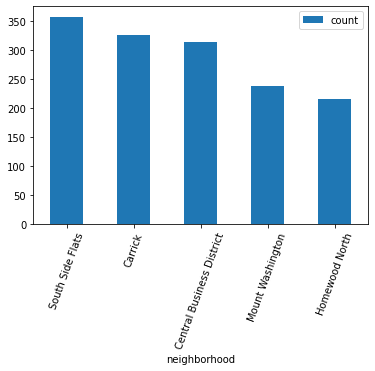

In [11]:
five_worst.plot.bar(x='neighborhood',rot=70)

In [12]:
ten_best = s.nsmallest(10,'count')
ten_best

,neighborhood,count
26,Troy Hill-Herrs Island,1.0
42,Outside County,1.0
82,Mt. Oliver Neighborhood,1.0
25,Central Northside,2.0
97,Mt. Oliver Boro,3.1
7,Regent Square,4.0
92,New Homestead,4.0
94,Swisshelm Park,4.0
78,St. Clair,5.0
72,Oakwood,6.0


The code above displays the top ten with the most dangerous arrests and environments, and the code below displays it as a bar graph. This allows the user to observe which neighboorhoods have the least amount of dangerous arrests.

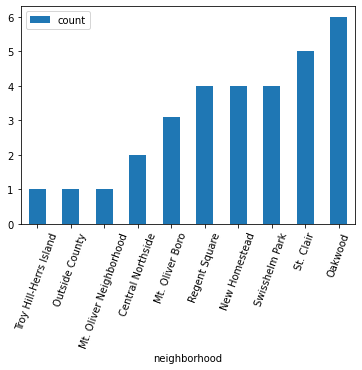

In [13]:
ten_best.plot.bar(x='neighborhood',rot=70)

The data on which neighborhood has the least amount of dangerous arrests is inconclusive. There are many neighborhoods with very low arrest values according to my analysis. In my opinion, any of the neighborhoods in the tops ten  are viable to be the best neighborhood in Pittsburgh given this data. However, South Side Flats is definitely the worst in terms of dangerous arrests, and it, along with Carrick, Central Business District, Mount Washigton, and Homewood North, does not deserve the title of best neighborhood.